# Setup e instalação das bibliotecas necessárias

In [ ]:
%%capture
!pip install datasets wandb accelerate transformers[torch] evaluate -Uq

In [ ]:
import torch, os, evaluate, wandb,datetime
from sklearn.metrics import classification_report
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset, load_dataset
import pandas as pd
from google.colab import drive
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, \
                            classification_report, f1_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification,\
                            Trainer,TrainingArguments, AutoConfig, EarlyStoppingCallback, IntervalStrategy


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
BASE_PATH = "/content/drive/MyDrive/IA-AzMina/modelos/"
RANDOM_SEED = 5151

dataset = load_dataset("belisards/ementas_anotadas")

README.md:   0%|          | 0.00/718 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/152k [00:00<?, ?B/s]

val-00000-of-00001.parquet:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1119 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/112 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/168 [00:00<?, ? examples/s]

# Carregar o dataset para treino

In [ ]:
#print para conferir a estrutura do dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label_tema', 'label_desfavoravel', 'proponente_mulher', 'partido', '__index_level_0__'],
        num_rows: 1119
    })
    val: Dataset({
        features: ['id', 'text', 'label_tema', 'label_desfavoravel', 'proponente_mulher', 'partido', '__index_level_0__'],
        num_rows: 112
    })
    test: Dataset({
        features: ['id', 'text', 'label_tema', 'label_desfavoravel', 'proponente_mulher', 'partido', '__index_level_0__'],
        num_rows: 168
    })
})

In [ ]:
#estrutura o dataset
cols = ["text","label"]
fix_columns = {"label_tema":"label"}
train = dataset["train"].to_pandas().rename(columns=fix_columns)[cols]
val = dataset["val"].to_pandas().rename(columns=fix_columns)[cols]
test = dataset["test"].to_pandas().rename(columns=fix_columns)[cols]

In [ ]:
val.label.value_counts()

,count
label,
violencia contra a mulher,36
maternidade,13
direitos sociais,13
direitos sexuais e reprodutivos,12
dignidade sexual,11
economia,10
genero,8
politica,6
feminicidio,3


In [ ]:
test.label.value_counts()

,count
label,
violencia contra a mulher,54
maternidade,19
direitos sexuais e reprodutivos,19
direitos sociais,19
dignidade sexual,17
economia,14
genero,13
politica,8
feminicidio,5


In [ ]:
train.label.value_counts()

,count
label,
violencia contra a mulher,361
direitos sociais,129
maternidade,126
direitos sexuais e reprodutivos,125
dignidade sexual,114
economia,96
genero,82
politica,55
feminicidio,31


# Carrega o modelo

In [ ]:
unique_labels = train.label.unique()

label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for i, label in enumerate(unique_labels)}

In [ ]:
pretrainedmodel = 'belisards/congretimbau3'

model = AutoModelForSequenceClassification.from_pretrained(pretrainedmodel,
                                                           num_labels=len(unique_labels),
                                                           id2label=id2label,
                                                           label2id=label2id,
                                                           hidden_dropout_prob=0.05,
                                                           attention_probs_dropout_prob=0.05)

tokenizer = AutoTokenizer.from_pretrained(pretrainedmodel,do_lower_case=False)

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at belisards/congretimbau3 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

# Define número máximo de tokens

Map:   0%|          | 0/1119 [00:00<?, ? examples/s]

Max length: 265


<Axes: >

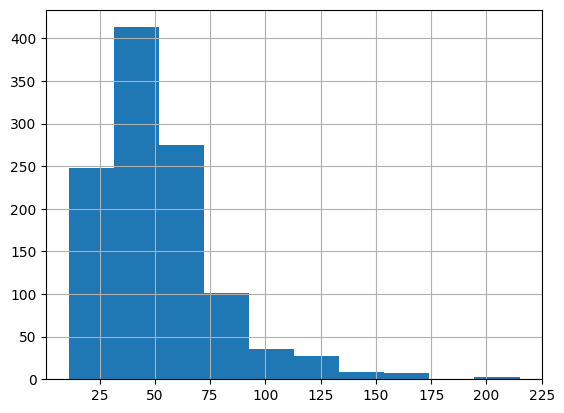

In [ ]:
def tokenize_function(record,max_length=512):
    return tokenizer(record['text'], truncation=True, padding='max_length', max_length=max_length)

tokens_train = Dataset.from_pandas(train).map(tokenize_function, batched=True)
tokens_dist = pd.Series([len([v for v in seq if v != 0]) for seq in tokens_train['input_ids']])
MAX_LENGTH = np.max(tokens_dist) + 50
print(f"Max length: {MAX_LENGTH}")
tokens_dist.hist()


# train = Dataset.from_pandas(df).map(lambda x: tokenize_function(x, max_length=MAX_LENGTH), batched=True)
# test = Dataset.from_pandas(df_test).map(lambda x: tokenize_function(x, max_length=MAX_LENGTH), batched=True)

In [ ]:
def prepare_dataset(dataframe,label2id=label2id,max_length=MAX_LENGTH):
    df = dataframe.copy()
    # df.drop_duplicates(subset="text", inplace=True)
    # df.reset_index(drop=True,inplace=True)
    df["label"] = df["label"].apply(lambda x: label2id[x])
    dataset = Dataset.from_pandas(df)
    dataset = dataset.map(lambda x: tokenizer(x['text'], truncation=True, padding='max_length',max_length=MAX_LENGTH), batched=True)
    return dataset

train = prepare_dataset(train)
val = prepare_dataset(val)
test = prepare_dataset(test)

Map:   0%|          | 0/1119 [00:00<?, ? examples/s]

Map:   0%|          | 0/112 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

# Treina o modelo

In [ ]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
recall_metric = evaluate.load("recall")
precision_metric = evaluate.load("precision")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy_result = accuracy_metric.compute(predictions=predictions, references=labels)
    f1_result = f1_metric.compute(predictions=predictions, references=labels,average='macro')
    recall_result = recall_metric.compute(predictions=predictions, references=labels,average='macro')
    precision_result = precision_metric.compute(predictions=predictions, references=labels,average='macro')

    result = {**accuracy_result, **f1_result, **recall_result, **precision_result}
    return result

In [ ]:
#Define os parâmetros para o treinamento

batch_size = 32
eval_steps = 50

training_args = TrainingArguments(
    output_dir=BASE_PATH,
    eval_strategy="steps",
    eval_steps=eval_steps,
    save_strategy="steps",
    save_steps=eval_steps*2,
    warmup_steps=100,
    logging_steps=10,
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.02,
    seed=RANDOM_SEED,
    save_total_limit=1,
    report_to="wandb",
    metric_for_best_model="f1",
    run_name=wandb_run_name,
    load_best_model_at_end = True,
    optim="adamw_torch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=val,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


In [ ]:
#treina o modelo sem os dados que foram separados para avaliação
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
50,1.890900,1.893249,0.321429,0.054054,0.111111,0.035714
100,1.215900,1.145673,0.678571,0.528200,0.513431,0.628751
150,0.435600,0.669922,0.785714,0.761184,0.746618,0.802615
200,0.279500,0.578997,0.785714,0.780283,0.777672,0.788973
250,0.143400,0.634260,0.767857,0.725726,0.702756,0.795826
300,0.090700,0.638226,0.794643,0.756145,0.740933,0.818130
350,0.056000,0.645310,0.803571,0.787372,0.776960,0.817532


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=350, training_loss=0.7265969663006919, metrics={'train_runtime': 408.6487, 'train_samples_per_second': 27.383, 'train_steps_per_second': 0.856, 'total_flos': 5397593807232900.0, 'train_loss': 0.7265969663006919, 'epoch': 10.0})

In [ ]:
# {'eval_loss': 0.6319449543952942,
#  'eval_accuracy': 0.7857142857142857,
#  'eval_f1': 0.7697285373384223,
#  'eval_recall': 0.7575273619219267,
#  'eval_precision': 0.7933682259769217,
#  'eval_runtime': 1.7734,
#  'eval_samples_per_second': 94.736,
#  'eval_steps_per_second': 3.383,
#  'epoch': 14.571428571428571}
trainer.evaluate(test)

{'eval_loss': 0.6548914313316345,
 'eval_accuracy': 0.7857142857142857,
 'eval_f1': 0.776208888809188,
 'eval_recall': 0.7635359731936959,
 'eval_precision': 0.8002645502645502,
 'eval_runtime': 1.8117,
 'eval_samples_per_second': 92.73,
 'eval_steps_per_second': 3.312,
 'epoch': 10.0}

In [ ]:
# # push to hub
# trainer.push_to_hub("kairos-zmn_v0")

In [ ]:
#teste de um exemplo de label
sample_sentence = " Estabelece novas diretrizes e mecanismos de proteção às mulheres vítimas de violência doméstica e familiar, \
                    ampliando as disposições da Lei Maria da Penha (Lei n.º 11.340, de 7 de agosto de 2006)."

def predict_sentence(string):
  tokens = tokenizer(string, truncation=True, padding='max_length', max_length=MAX_LENGTH)
  input_ids = torch.tensor(tokens["input_ids"]).unsqueeze(0).to(device)
  attention_mask = torch.tensor(tokens["attention_mask"]).unsqueeze(0).to(device)
  outputs = model(input_ids, attention_mask=attention_mask)
  logits = outputs.logits
  label_id = torch.argmax(logits).item()
  label = id2label[label_id]
  return label

predict_sentence(sample_sentence)


'violencia contra a mulher'

In [ ]:
#conjunto de dados para avaliação
eval_test = test.to_pandas()
eval_test["pred_label"] = eval_test["text"].apply(lambda x: predict_sentence(x))
eval_test["pred_label"].value_counts()

,count
pred_label,
violencia contra a mulher,60
direitos sociais,24
maternidade,18
dignidade sexual,16
genero,14
direitos sexuais e reprodutivos,14
economia,10
politica,7
feminicidio,5


In [ ]:
#métricas do modelo
eval_test["label_name"] = eval_test["label"].apply(lambda x: id2label[x])
print(classification_report(eval_test["label_name"], eval_test["pred_label"]))


                                 precision    recall  f1-score   support

               dignidade sexual       0.88      0.82      0.85        17
direitos sexuais e reprodutivos       0.86      0.63      0.73        19
               direitos sociais       0.54      0.68      0.60        19
                       economia       0.70      0.50      0.58        14
                    feminicidio       0.80      0.80      0.80         5
                         genero       0.93      1.00      0.96        13
                    maternidade       0.67      0.63      0.65        19
                       politica       1.00      0.88      0.93         8
      violencia contra a mulher       0.83      0.93      0.88        54

                       accuracy                           0.79       168
                      macro avg       0.80      0.76      0.78       168
                   weighted avg       0.79      0.79      0.78       168



In [ ]:
# sobe o modelo para o Hugging Face, utilize as credenciais do projeto

trainer.push_to_hub("belisards/ia_m1_v1")

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/belisards/modelos/commit/a8e4787e20da05562863840322fcca90b9c1889d', commit_message='belisards/ia_m1_v1', commit_description='', oid='a8e4787e20da05562863840322fcca90b9c1889d', pr_url=None, pr_revision=None, pr_num=None)

# Agrega os dados de validação para fazer o treino final com o dado completo

In [ ]:
from datasets import concatenate_datasets

#juntar os datasets de treino e teste
combined_train_dataset = concatenate_datasets([train, val])


In [ ]:
pretrainedmodel = 'belisards/congretimbau3'

model = AutoModelForSequenceClassification.from_pretrained(pretrainedmodel,
                                                           num_labels=len(unique_labels),
                                                           id2label=id2label,
                                                           label2id=label2id,
                                                           hidden_dropout_prob=0.05,
                                                           attention_probs_dropout_prob=0.05)

tokenizer = AutoTokenizer.from_pretrained(pretrainedmodel,do_lower_case=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at belisards/congretimbau3 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#parâmetros para o treino final
batch_size = 32
eval_steps = 10

training_args = TrainingArguments(
    output_dir=BASE_PATH,
    #eval_strategy="steps",
    # eval_steps=eval_steps,
    #save_strategy="steps",
    # save_steps=eval_steps*2,
    warmup_steps=50,
    logging_steps=5,
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=8,
    weight_decay=0.025,
    seed=RANDOM_SEED,
    save_total_limit=1,
    report_to="wandb",
    metric_for_best_model="f1",
    run_name=wandb_run_name,
    # load_best_model_at_end = True,
    optim="adamw_torch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=combined_train_dataset,
   # eval_dataset=val,
    compute_metrics=compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


In [ ]:
#treina o modelo
trainer.train()

Step,Training Loss
5,2.168900
10,2.108800
15,2.078200
20,2.090000
25,1.991000
30,1.964600
35,1.891000
40,1.871700
45,1.815700
50,1.660000


TrainOutput(global_step=312, training_loss=0.7348582876416353, metrics={'train_runtime': 321.1579, 'train_samples_per_second': 30.664, 'train_steps_per_second': 0.971, 'total_flos': 4750268437321680.0, 'train_loss': 0.7348582876416353, 'epoch': 8.0})

In [ ]:
#avaliação do treino final do modelo
# {'eval_loss': 0.6319449543952942,
#  'eval_accuracy': 0.7857142857142857,
#  'eval_f1': 0.7697285373384223,
#  'eval_recall': 0.7575273619219267,
#  'eval_precision': 0.7933682259769217,
#  'eval_runtime': 1.7734,
#  'eval_samples_per_second': 94.736,
#  'eval_steps_per_second': 3.383,
#  'epoch': 14.571428571428571}
trainer.evaluate(test)

{'eval_loss': 0.5892046093940735,
 'eval_accuracy': 0.8154761904761905,
 'eval_f1': 0.7939121851415706,
 'eval_recall': 0.7934637337716113,
 'eval_precision': 0.8062792677735207,
 'eval_runtime': 1.8369,
 'eval_samples_per_second': 91.46,
 'eval_steps_per_second': 3.266,
 'epoch': 8.0}

In [ ]:
#teste de um exemplo
sample_sentence = " Estabelece novas diretrizes e mecanismos de proteção às mulheres vítimas de violência doméstica e familiar, \
                    ampliando as disposições da Lei Maria da Penha (Lei n.º 11.340, de 7 de agosto de 2006)."

def predict_sentence(string):
  tokens = tokenizer(string, truncation=True, padding='max_length', max_length=MAX_LENGTH)
  input_ids = torch.tensor(tokens["input_ids"]).unsqueeze(0).to(device)
  attention_mask = torch.tensor(tokens["attention_mask"]).unsqueeze(0).to(device)
  outputs = model(input_ids, attention_mask=attention_mask)
  logits = outputs.logits
  label_id = torch.argmax(logits).item()
  label = id2label[label_id]
  return label

predict_sentence(sample_sentence)


'violencia contra a mulher'

In [ ]:
#métricas do modelo treinado
eval_test = test.to_pandas()
eval_test["pred_label"] = eval_test["text"].apply(lambda x: predict_sentence(x))
eval_test["pred_label"].value_counts()
eval_test["label_name"] = eval_test["label"].apply(lambda x: id2label[x])
print(classification_report(eval_test["label_name"], eval_test["pred_label"]))


                                 precision    recall  f1-score   support

               dignidade sexual       0.94      0.88      0.91        17
direitos sexuais e reprodutivos       0.89      0.84      0.86        19
               direitos sociais       0.61      0.58      0.59        19
                       economia       0.78      0.50      0.61        14
                    feminicidio       0.67      0.80      0.73         5
                         genero       0.81      1.00      0.90        13
                    maternidade       0.70      0.74      0.72        19
                       politica       1.00      0.88      0.93         8
      violencia contra a mulher       0.86      0.93      0.89        54

                       accuracy                           0.82       168
                      macro avg       0.81      0.79      0.79       168
                   weighted avg       0.82      0.82      0.81       168



In [ ]:
#push para o Hugging Face
trainer.push_to_hub("ia_feminista_tema")


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/belisards/modelos/commit/6872daa8bb5744c76c08fe2c3c2fce31e5d9da32', commit_message='ia_feminista_tema', commit_description='', oid='6872daa8bb5744c76c08fe2c3c2fce31e5d9da32', pr_url=None, pr_revision=None, pr_num=None)